# Wood Anomaly Detection — Baseline (RAW)
Bu notebook, **train/good** ile 3 farklı AutoEncoder’ı (ShallowAE, CNNAE, UNetAE) eğitir; 
**test/{good, defect}** üzerinde yeniden-üretim hatasına dayalı anomali skoru üretir.

**Çıktılar:**
- ROC-AUC, F1, Confusion Matrix
- Örnek rekonstrüksiyon ve hata haritası görselleri
- Model ağırlıkları
- Sonuç CSV’leri


In [ ]:
import os, random, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve


SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
DATA_ROOT   = "Dataset/wood"        # RAW veri için
OUTPUT_ROOT = "outputs_raw"         # Çıktı klasörü (RAW)

IMG_SIZE   = 256
BATCH_SIZE = 16
EPOCHS     = 20
LR         = 1e-3

os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(f"{OUTPUT_ROOT}/models", exist_ok=True)
os.makedirs(f"{OUTPUT_ROOT}/viz", exist_ok=True)

print("DATA_ROOT:", DATA_ROOT)


DATA_ROOT: Dataset/wood


In [3]:
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_dir = os.path.join(DATA_ROOT, "train")
test_dir  = os.path.join(DATA_ROOT, "test")

train_ds = datasets.ImageFolder(train_dir, transform=transform_train)
test_ds  = datasets.ImageFolder(test_dir,  transform=transform_test)

print("test_ds.classes:", test_ds.classes)  # ['defect', 'good'] veya ['good','defect'] olabilir

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train images: {len(train_ds)} | Test images: {len(test_ds)}")


test_ds.classes: ['defect', 'good']
Train images: 90 | Test images: 46


In [4]:
def auto_threshold(errors, k=2.0):
    mu = np.mean(errors)
    sd = np.std(errors)
    return mu + k * sd

def evaluate_scores(y_true, scores, thresh=None):
    y_true = np.array(y_true).astype(int)
    scores = np.array(scores).astype(float)
    roc = roc_auc_score(y_true, scores)
    if thresh is None:
        thresh = auto_threshold(scores, k=2.0)
    y_pred = (scores > thresh).astype(int)
    f1  = f1_score(y_true, y_pred)
    cm  = confusion_matrix(y_true, y_pred)
    return {"roc_auc": float(roc), "f1": float(f1), "cm": cm, "threshold": float(thresh), "y_pred": y_pred}


In [5]:
class ShallowAE(nn.Module):
    def __init__(self, in_ch=3, base=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, base, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(base, base*2, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(base*2, base*4, 3, 2, 1), nn.ReLU(True),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(base*4, base*2, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(base*2, base,   4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(base, in_ch,    4, 2, 1), nn.Sigmoid(),
        )
    def forward(self, x):
        z = self.enc(x)
        return self.dec(z)

class CNNAE(nn.Module):
    def __init__(self, in_ch=3, base=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, base, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(base, base, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(base, base*2, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(base*2, base*2, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(base*2, base*4, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(base*4, base*4, 3, 1, 1), nn.ReLU(True),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(base*4, base*2, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(base*2, base*2, 3, 1, 1), nn.ReLU(True),
            nn.ConvTranspose2d(base*2, base, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(base, base, 3, 1, 1), nn.ReLU(True),
            nn.ConvTranspose2d(base, in_ch, 4, 2, 1), nn.Sigmoid(),
        )
    def forward(self, x):
        z = self.enc(x)
        return self.dec(z)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(True),
        )
    def forward(self, x):
        return self.block(x)

class UNetAE(nn.Module):
    def __init__(self, in_ch=3, base=32):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(base*4, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = ConvBlock(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = ConvBlock(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = ConvBlock(base*2, base)

        self.out = nn.Conv2d(base, in_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b  = self.bottleneck(self.pool3(e3))
        d3 = self.up3(b); d3 = torch.cat([d3, e3], dim=1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat([d2, e2], dim=1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat([d1, e1], dim=1); d1 = self.dec1(d1)
        return torch.sigmoid(self.out(d1))


In [6]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    for x, _ in loader:
        x = x.to(device)
        xhat = model(x)
        loss = criterion(xhat, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def infer_scores(model, loader):
    model.eval()
    scores, labels, samples = [], [], []
    for x, y in loader:
        x = x.to(device)
        xhat = model(x)
        per_sample = torch.mean((xhat - x)**2, dim=[1,2,3]).detach().cpu().numpy()
        scores.extend(per_sample.tolist())
        labels.extend(y.numpy().tolist())
        samples.append((x.detach().cpu(), xhat.detach().cpu()))
    return np.array(scores), np.array(labels), samples

def save_sample_visuals(model_name, sample_batches, out_dir, max_batches=2):
    os.makedirs(out_dir, exist_ok=True)
    cnt = 0
    for x, xhat in sample_batches:
        if cnt >= max_batches: break
        err = torch.abs(xhat - x)
        grid_in  = vutils.make_grid(x,    nrow=4, normalize=True)
        grid_out = vutils.make_grid(xhat, nrow=4, normalize=True)
        grid_err = vutils.make_grid(err,  nrow=4, normalize=True)

        plt.figure(figsize=(12,4)); plt.imshow(np.transpose(grid_in.numpy(), (1,2,0))); plt.axis("off"); plt.title("Originals")
        plt.tight_layout(); plt.savefig(f"{out_dir}/{model_name}_orig_{cnt}.png"); plt.close()

        plt.figure(figsize=(12,4)); plt.imshow(np.transpose(grid_out.numpy(), (1,2,0))); plt.axis("off"); plt.title("Reconstructions")
        plt.tight_layout(); plt.savefig(f"{out_dir}/{model_name}_recon_{cnt}.png"); plt.close()

        plt.figure(figsize=(12,4)); plt.imshow(np.transpose(grid_err.numpy(), (1,2,0))); plt.axis("off"); plt.title("|Error|")
        plt.tight_layout(); plt.savefig(f"{out_dir}/{model_name}_error_{cnt}.png"); plt.close()

        cnt += 1

def train_and_eval(model_name, ctor, epochs=EPOCHS, lr=LR):
    print(f"\\n===== {model_name} =====")
    model = ctor().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_loss = float("inf")
    best_path = f"{OUTPUT_ROOT}/models/{model_name}_best.pt"

    for ep in range(1, epochs+1):
        tr_loss = train_one_epoch(model, train_loader, opt, criterion)
        print(f"Epoch {ep:02d}/{epochs} | train_loss={tr_loss:.6f}")
        if tr_loss < best_loss:
            best_loss = tr_loss
            torch.save(model.state_dict(), best_path)

    model.load_state_dict(torch.load(best_path, map_location=device))
    scores, labels, sample_batches = infer_scores(model, test_loader)

    metrics = evaluate_scores(labels, scores, thresh=None)
    print("Metrics:", metrics)

    # Save scores & metrics
    pd.DataFrame({"score": scores, "label": labels}).to_csv(
        f"{OUTPUT_ROOT}/{model_name}_scores.csv", index=False
    )
    with open(f"{OUTPUT_ROOT}/{model_name}_metrics.json", "w") as f:
        json.dump(
            {k: (v.tolist() if hasattr(v, "tolist") else v) for k,v in metrics.items()},
            f, indent=2
        )

    # Visuals
    save_sample_visuals(model_name, sample_batches, f"{OUTPUT_ROOT}/viz")

    return metrics


In [7]:
results = {}
results["ShallowAE"] = train_and_eval("ShallowAE", lambda: ShallowAE(in_ch=3, base=32))
results["CNNAE"]     = train_and_eval("CNNAE",     lambda: CNNAE(in_ch=3, base=32))
results["UNetAE"]    = train_and_eval("UNetAE",    lambda: UNetAE(in_ch=3, base=32))

rows = []
for name, m in results.items():
    rows.append({
        "model": name,
        "roc_auc": m["roc_auc"],
        "f1": m["f1"],
        "threshold": m["threshold"],
        "cm": m["cm"].tolist(),
    })
df_res = pd.DataFrame(rows)
df_res.to_csv(f"{OUTPUT_ROOT}/summary_metrics.csv", index=False)
df_res


\n===== ShallowAE =====
Epoch 01/20 | train_loss=0.147970
Epoch 02/20 | train_loss=0.104452
Epoch 03/20 | train_loss=0.033099
Epoch 04/20 | train_loss=0.019280
Epoch 05/20 | train_loss=0.016696
Epoch 06/20 | train_loss=0.011892
Epoch 07/20 | train_loss=0.007481
Epoch 08/20 | train_loss=0.004752
Epoch 09/20 | train_loss=0.003631
Epoch 10/20 | train_loss=0.002872
Epoch 11/20 | train_loss=0.002375
Epoch 12/20 | train_loss=0.002014
Epoch 13/20 | train_loss=0.001760
Epoch 14/20 | train_loss=0.001607
Epoch 15/20 | train_loss=0.001493
Epoch 16/20 | train_loss=0.001411
Epoch 17/20 | train_loss=0.001315
Epoch 18/20 | train_loss=0.001237
Epoch 19/20 | train_loss=0.001181
Epoch 20/20 | train_loss=0.001130


C:\Users\Yasin\AppData\Local\Temp\ipykernel_25268\2225951144.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=de

Metrics: {'roc_auc': 0.1611111111111111, 'f1': 0.0, 'cm': array([[36,  0],
       [10,  0]], dtype=int64), 'threshold': 0.0023302864894042944, 'y_pred': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])}
\n===== CNNAE =====
Epoch 01/20 | train_loss=0.138027
Epoch 02/20 | train_loss=0.106064
Epoch 03/20 | train_loss=0.037506
Epoch 04/20 | train_loss=0.031109
Epoch 05/20 | train_loss=0.025880
Epoch 06/20 | train_loss=0.020694
Epoch 07/20 | train_loss=0.018209
Epoch 08/20 | train_loss=0.016231
Epoch 09/20 | train_loss=0.015156
Epoch 10/20 | train_loss=0.014221
Epoch 11/20 | train_loss=0.012921
Epoch 12/20 | train_loss=0.008826
Epoch 13/20 | train_loss=0.005472
Epoch 14/20 | train_loss=0.003510
Epoch 15/20 | train_loss=0.002347
Epoch 16/20 | train_loss=0.001783
Epoch 17/20 | train_loss=0.001586
Epoch 18/20 | train_loss=0.001465
Epoch 19/20 | train_loss=0.001342
Epoch 20/20 | train_

C:\Users\Yasin\AppData\Local\Temp\ipykernel_25268\2225951144.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=de

Metrics: {'roc_auc': 0.08611111111111111, 'f1': 0.0, 'cm': array([[36,  0],
       [10,  0]], dtype=int64), 'threshold': 0.0038729413354906452, 'y_pred': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])}
\n===== UNetAE =====
Epoch 01/20 | train_loss=0.138245
Epoch 02/20 | train_loss=0.112739
Epoch 03/20 | train_loss=0.032095
Epoch 04/20 | train_loss=0.017866
Epoch 05/20 | train_loss=0.007514
Epoch 06/20 | train_loss=0.003876
Epoch 07/20 | train_loss=0.002594
Epoch 08/20 | train_loss=0.002287
Epoch 09/20 | train_loss=0.001787
Epoch 10/20 | train_loss=0.001477
Epoch 11/20 | train_loss=0.001313
Epoch 12/20 | train_loss=0.001150
Epoch 13/20 | train_loss=0.000987
Epoch 14/20 | train_loss=0.000894
Epoch 15/20 | train_loss=0.000825
Epoch 16/20 | train_loss=0.000777
Epoch 17/20 | train_loss=0.000735
Epoch 18/20 | train_loss=0.000715
Epoch 19/20 | train_loss=0.000671
Epoch 20/20 | trai

C:\Users\Yasin\AppData\Local\Temp\ipykernel_25268\2225951144.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=de

Metrics: {'roc_auc': 0.1305555555555556, 'f1': 0.0, 'cm': array([[36,  0],
       [10,  0]], dtype=int64), 'threshold': 0.002123755585487939, 'y_pred': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])}


,model,roc_auc,f1,threshold,cm
0,ShallowAE,0.161111,0.0,0.002330,"[[36, 0], [10, 0]]"
1,CNNAE,0.086111,0.0,0.003873,"[[36, 0], [10, 0]]"
2,UNetAE,0.130556,0.0,0.002124,"[[36, 0], [10, 0]]"


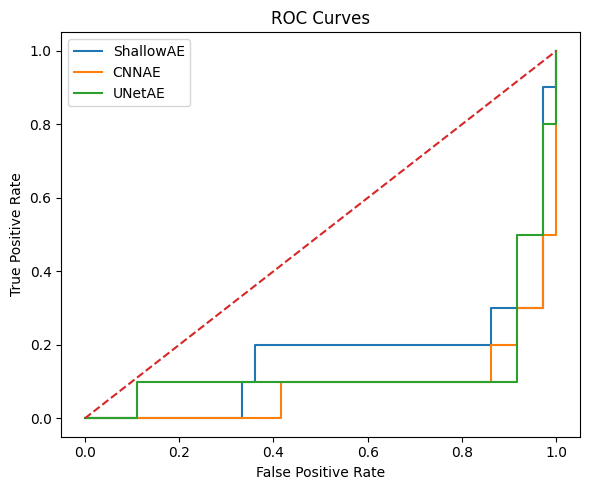

In [8]:
plt.figure(figsize=(6,5))
for name in ["ShallowAE", "CNNAE", "UNetAE"]:
    csv_path = f"{OUTPUT_ROOT}/{name}_scores.csv"
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        fpr, tpr, _ = roc_curve(df["label"].values, df["score"].values)
        plt.plot(fpr, tpr, label=name)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves"); plt.legend(); plt.tight_layout()
plt.savefig(f"{OUTPUT_ROOT}/viz/roc_curves.png")
plt.show()



===== ShallowAE — Prediction Table =====
   label  pred     score result
0      0     0  0.001304     TN
1      0     0  0.000935     TN
2      0     0  0.001121     TN
3      0     0  0.001787     TN
4      0     0  0.001178     TN
5      0     0  0.002083     TN
6      0     0  0.001834     TN
7      0     0  0.001737     TN
8      0     0  0.001587     TN
9      0     0  0.001420     TN


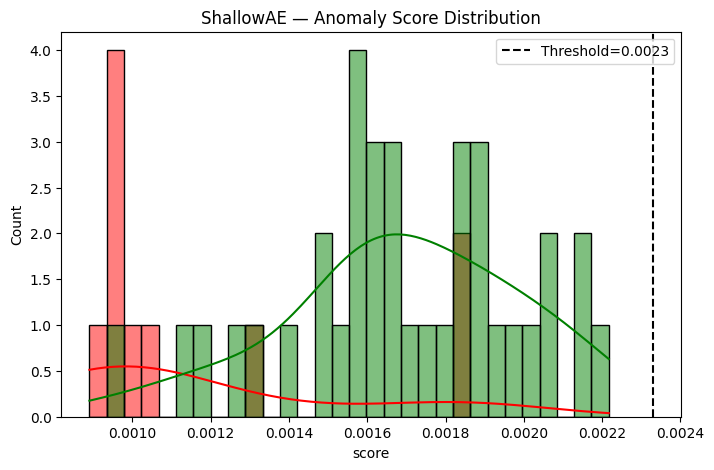

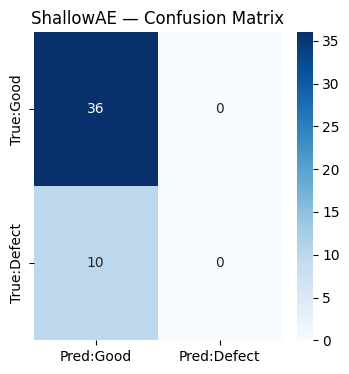

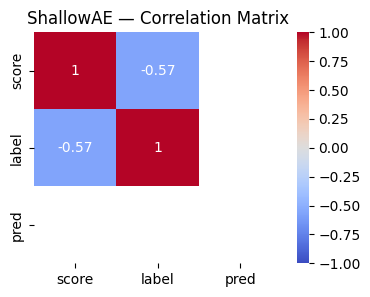


📊 Performance Summary for ShallowAE
ROC-AUC : 0.1611
F1-Score: 0.0000
Accuracy : 0.7826
Precision: 0.0000
Recall   : 0.0000

===== CNNAE — Prediction Table =====
   label  pred     score result
0      0     0  0.001309     TN
1      0     0  0.001105     TN
2      0     0  0.001256     TN
3      0     0  0.001598     TN
4      0     0  0.001552     TN
5      0     0  0.003183     TN
6      0     0  0.002920     TN
7      0     0  0.002842     TN
8      0     0  0.002385     TN
9      0     0  0.001883     TN


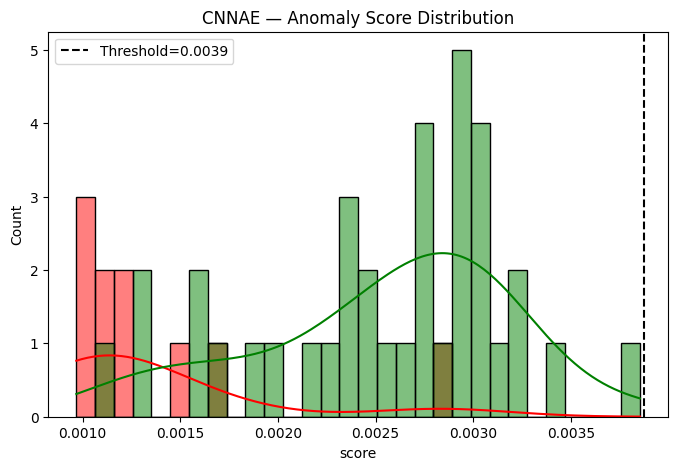

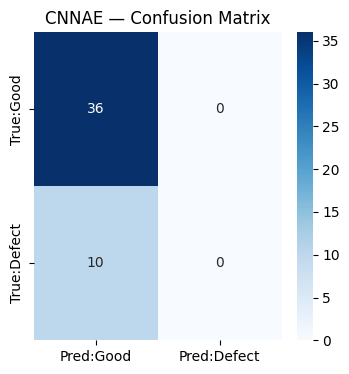

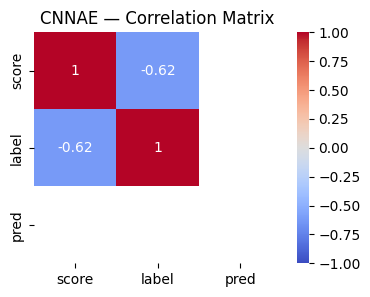


📊 Performance Summary for CNNAE
ROC-AUC : 0.0861
F1-Score: 0.0000
Accuracy : 0.7826
Precision: 0.0000
Recall   : 0.0000

===== UNetAE — Prediction Table =====
   label  pred     score result
0      0     0  0.000631     TN
1      0     0  0.000616     TN
2      0     0  0.000634     TN
3      0     0  0.000742     TN
4      0     0  0.000888     TN
5      0     0  0.001585     TN
6      0     0  0.001557     TN
7      0     0  0.001592     TN
8      0     0  0.001438     TN
9      0     0  0.001090     TN


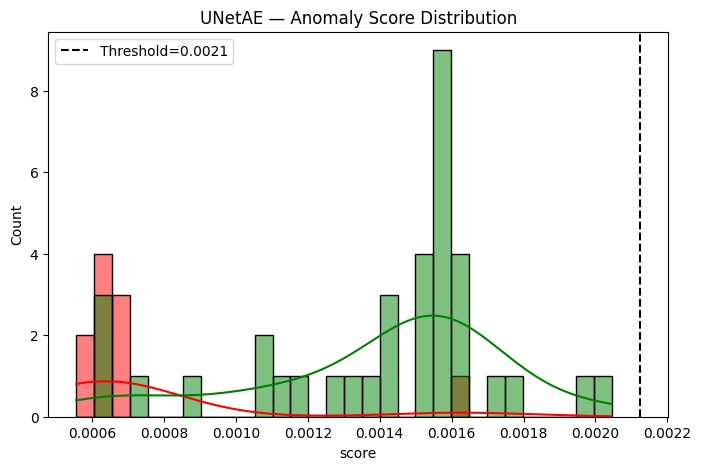

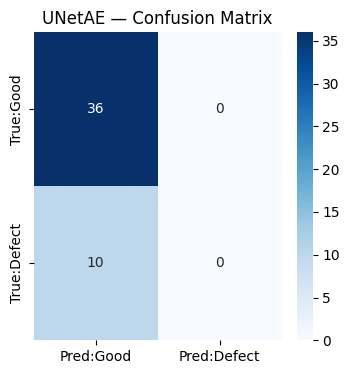

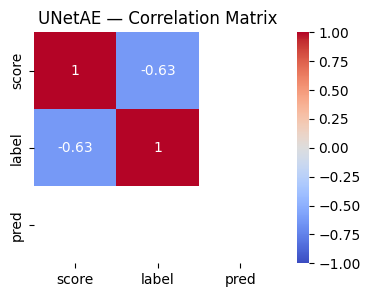


📊 Performance Summary for UNetAE
ROC-AUC : 0.1306
F1-Score: 0.0000
Accuracy : 0.7826
Precision: 0.0000
Recall   : 0.0000


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_predictions_in_memory(model_name, output_root=OUTPUT_ROOT):
    """
    In-memory evaluation: read scores & metrics, visualize, print stats.
    No file output is created.
    """
    csv_path = f"{output_root}/{model_name}_scores.csv"
    metrics_path = f"{output_root}/{model_name}_metrics.json"
    df = pd.read_csv(csv_path)
    with open(metrics_path, "r") as f:
        metrics = json.load(f)
    thr = metrics["threshold"]

    # Predict & classify correctness
    df["pred"] = (df["score"] > thr).astype(int)
    df["result"] = np.where(
        (df["label"] == 1) & (df["pred"] == 1), "TP",
        np.where((df["label"] == 0) & (df["pred"] == 0), "TN",
                 np.where((df["label"] == 0) & (df["pred"] == 1), "FP", "FN"))
    )

    # 1️⃣  Doğru / yanlış tablo özeti
    print(f"\n===== {model_name} — Prediction Table =====")
    print(df.head(10)[["label","pred","score","result"]])

    # 2️⃣  Skor dağılımı
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x="score", hue="label", bins=30, kde=True, palette=["green","red"])
    plt.axvline(thr, color="black", linestyle="--", label=f"Threshold={thr:.4f}")
    plt.legend()
    plt.title(f"{model_name} — Anomaly Score Distribution")
    plt.show()

    # 3️⃣  Confusion matrix (ısı haritası)
    cm = np.array(metrics["cm"])
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred:Good","Pred:Defect"],
                yticklabels=["True:Good","True:Defect"])
    plt.title(f"{model_name} — Confusion Matrix")
    plt.show()

    # 4️⃣  Korelasyon matrisi
    corr = df[["score","label","pred"]].corr()
    plt.figure(figsize=(4,3))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"{model_name} — Correlation Matrix")
    plt.show()

    # 5️⃣  Sayısal metrikler
    print(f"\n📊 Performance Summary for {model_name}")
    print(f"ROC-AUC : {metrics['roc_auc']:.4f}")
    print(f"F1-Score: {metrics['f1']:.4f}")
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / np.sum(cm)
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")

    return df

# Her model için analiz çalıştır
dfs_analysis = {}
for name in ["ShallowAE","CNNAE","UNetAE"]:
    if os.path.exists(f"{OUTPUT_ROOT}/{name}_scores.csv"):
        dfs_analysis[name] = analyze_predictions_in_memory(name)
